In [44]:
import csv
import json
import pickle
import numpy as np
from scipy.stats import pearsonr, ttest_rel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import maxabs_scale
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
%matplotlib inline

In [29]:
# Preprocess data
def preprocess(tweets):
    REPLACE_NO_SPACE = re.compile("[.;:!\'?,\"()\[\]]")
    REPLACE_USER = re.compile("@.+?\s")
    tweets = [REPLACE_NO_SPACE.sub("", line.lower()) for line in tweets]
    tweets = [REPLACE_USER.sub("@_ ", line.lower()) for line in tweets]
    return tweets

In [30]:
# Get features for a tweet using count vectorizer
def get_feats(tweets):
    feats = cv.transform(tweets)
    feats = maxabs_scale(feats)
    return feats

In [31]:
# Load in model trained on large set of tweets
cv = pickle.load(open("vectorizer.p", "rb"))
final_model = pickle.load(open("model.p", "rb"))

In [47]:
# Load movie data
movie_tweets = json.load(open("movie_data/movie_tweets_week.json", "r"))
movie_tweets_no_bots = json.load(open("movie_data/movie_tweets_week_no_bots.json", "r"))

In [90]:
movie_scores = {}
movie_scores_bots = []
movie_scores_no_bots = []

In [91]:
# Get average sentiment for each movie with bots filtered out
for movie, data in sorted(movie_tweets_no_bots.items(), key=lambda x:x[0]):
    tweets = [tweet["text"] for tweet in data]
    feats = get_feats(tweets)
    preds = final_model.predict(feats)
    # Weight by likes
    likes = [tweet["favorite_count"] for tweet in data]
    preds = np.multiply(preds, likes)
    preds = np.divide(preds, sum(likes))
    movie_scores_no_bots.append(np.sum(preds, axis=0))

In [92]:
# Get average sentiment for each movie with bots included
for movie, data in sorted(movie_tweets.items(), key=lambda x:x[0]):
    tweets = [tweet["text"] for tweet in data]
    feats = get_feats(tweets)
    preds = final_model.predict(feats)
    # Weight by likes
    likes = [tweet["favorite_count"] for tweet in data]
    preds = np.multiply(preds, likes)
    preds = np.divide(preds, sum(likes))
    movie_scores[movie] = [np.sum(preds, axis=0), None, None]
    movie_scores_bots.append(np.sum(preds, axis=0))
    print(movie, np.sum(preds, axis=0))

Ad Astra 0.9240174672489082
Angel Has Fallen 0.6033138401559455
Avengers: Endgame 0.8469306404464523
Birds of Prey 0.7113070011866418
Coffee & Kareem 0.9378612716763005
Detective Pikachu 0.7338949454905848
Frozen II 0.5789748953974896
Gemini Man 0.9228159457167091
Hobbs & Shaw 0.9247491638795986
Jojo Rabbit 0.8427947598253274
Klaus 0.6141429669485011
Knives Out 0.5727163461538461
Marriage Story 0.912130177514793
Queen & Slim 0.46828046744574287
Spies in Disguise 0.7822736030828517
The Irishman 0.6930299747201156
The Two Popes 0.8826446280991735
Trolls World Tour 0.8087248322147651
Uncut Gems 0.8093994778067886
Vivarium 0.8226018396846255


In [93]:
# Compare bots with no bots
tstat, pval = ttest_rel(movie_scores_no_bots, movie_scores_bots)
print("T-stat: {}, p-value: {}".format(tstat, pval))
print("Mean with bots: ", np.mean(movie_scores_bots))
print("Mean with no bots: ", np.mean(movie_scores_no_bots))

T-stat: -2.0823849344330654, p-value: 0.05106224348645614
Mean with bots:  0.769630212234758
Mean with no bots:  0.7690090248041608


In [94]:
# Load in critic and audience scores
with open("movie_data/movie_info.csv", "r") as review_file:
    review_reader = csv.reader(review_file)
    next(review_reader)
    for row in review_reader:
        movie_scores[row[0]][1] = int(row[5])/100
        movie_scores[row[0]][2] = int(row[4])/100

Correlation =  -0.4726906607753055
p-value     =  0.035316558796699336


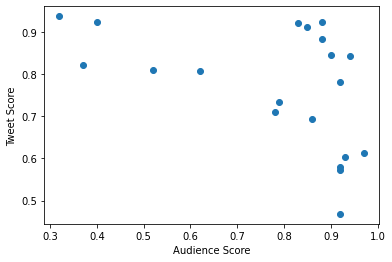

In [95]:
# Get correlation with audience score
x = [score[1] for score in movie_scores.values()]
y = [score[0] for score in movie_scores.values()]
corr, p = pearsonr(x, y)
print("Correlation = ", corr)
print("p-value     = ", p)
plt.scatter(x, y)
plt.xlabel("Audience Score")
plt.ylabel("Tweet Score")
plt.show()

Correlation =  -0.2604838847382356
p-value     =  0.267345210435997


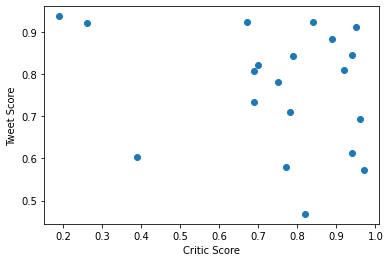

In [96]:
# Get correlation with critic score
x = [score[2] for score in movie_scores.values()]
y = [score[0] for score in movie_scores.values()]
corr, p = pearsonr(x, y)
print("Correlation = ", corr)
print("p-value     = ", p)
plt.scatter(x, y)
plt.xlabel("Critic Score")
plt.ylabel("Tweet Score")
plt.show()